In [1]:
# https://medium.com/@thakermadhav/build-your-own-rag-with-mistral-7b-and-langchain-97d0c92fa146

In [2]:
import os
import json
from pathlib import Path

In [3]:
# Configuration

# FAISS
faiss_gpu = False
faiss_embedding_model_name = 'jinaai/jina-embeddings-v2-base-en'
retrieve_topk = 6

# Text splitting settings
chunk_size = 1000
chunk_overlap = 200

# Rag settings
consistency_samples = 9

# Quantization settings
quantization_enabled = True
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = True

# Model
# model_name='mistralai/Mistral-7B-Instruct-v0.1'
model_name='teknium/OpenHermes-2.5-Mistral-7B'
# model_name='deepseek-ai/deepseek-coder-6.7b-instruct'
# model_name='ise-uiuc/Magicoder-S-DS-6.7B'
load_model_with_transformers = False
# model_name='Intel/neural-chat-7b-v3-1'
# model_name='rishiraj/CatPPT'
# model_name = 'kyujinpy/Sakura-SOLAR-Instruct'

tgi_url = "http://tgi:80"

batch_size = 16

grader_model_name = 'cognitivecomputations/dolphin-2_6-phi-2'

# Data
data_path = Path("./munchkin_rules/")

device = "cuda"

In [4]:
# nltk is used for PDF processing. Here we ensure anything it downloads goes to
# the cache folder, so it doesn't have to download again
nltk_data_path = Path("~/.cache/nltk_data").expanduser()
nltk_data_path.mkdir(parents=True, exist_ok=True)
os.environ["NLTK_DATA"] = str(nltk_data_path)

In [5]:
!sudo apt-get install -y poppler-utils tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


In [6]:
# !pip install humanize
# !pip install psutil

In [7]:
# # Deps for PDF parsing
# !pip install "unstructured[pdf]"
# !sudo apt-get install -y poppler-utils tesseract-ocr

# # I can't even remember why we need this one
# !pip install sentence-transformers

# # For phi-2
# !pip install einops

# # Flash attention
# !pip install -U flash-attn --no-build-isolation

In [8]:
# !pip install text_generation==0.6.1
# !pip install langchain==0.0.354
# !pip install langchain-community==0.0.8
# !pip install langchain-core==0.1.5
# !pip install langsmith==0.0.77
# langchain-community                      0.0.8
# langchain-core                           0.1.5
# langsmith                                0.0.77

In [9]:
# !pip install ipywidgets

In [10]:
# !pip uninstall faiss faiss-gpu -y
# !pip install faiss-cpu

In [11]:
from typing import Optional, Tuple

import copy
import torch
import transformers

from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.chains import LLMChain
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.llms.huggingface_pipeline import HuggingFacePipeline
from langchain.prompts import PromptTemplate, StringPromptTemplate
from langchain.retrievers import ParentDocumentRetriever
from langchain.schema import AIMessage, SystemMessage, HumanMessage
from langchain.schema.runnable import RunnablePassthrough
from langchain.storage import InMemoryStore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import VectorStore
from langchain_community.chat_models import ChatHuggingFace
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.llms import HuggingFaceTextGenInference
from langchain_community.vectorstores.chroma import Chroma
from langchain_community.vectorstores.faiss import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_core.language_models import BaseChatModel
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import Runnable
from langchain_core.runnables import RunnableBranch
from transformers import (
    PreTrainedModel, 
    PreTrainedTokenizerBase,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoModel,
)

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
from util import VectorStoreRetrieverWithTextSplitter
from meeplemate.llm_models import (
    load_tgi_chat_model,
    load_tokenizer,
    load_jina_embedding_model,
    sentence_transformer_to_hf_embeddings
)
from meeplemate.vectorstores import (
    build_vectorstore_faiss,
)
from meeplemate.retrievers import (
    build_retriever,
)
from meeplemate.consistency import (
    rank_responses_by_majority_consensus,
    build_universal_consistency_chain
)
from meeplemate.pdf import parse_pdf

In [14]:
print(f"{transformers.__version__=}")
print(f"{torch.__version__=}")
print(f"{torch.version.cuda=}")
print(f"{torch.cuda.is_available()=}")
print(f"{torch.cuda.device_count()=}")

if "cuda" in device:
    assert torch.cuda.is_available(), "CUDA is not available"

transformers.__version__='4.36.0'
torch.__version__='2.1.1+cu118'
torch.version.cuda='11.8'
torch.cuda.is_available()=True
torch.cuda.device_count()=1


In [15]:
!nvidia-smi

Sun Feb 18 01:43:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:07:00.0  On |                  N/A |
|  0%   60C    P5              45W / 420W |  18363MiB / 24576MiB |     29%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
!curl http://tgi:80/info

{"model_id":"TheBloke/OpenHermes-2.5-Mistral-7B-AWQ","model_sha":"a0e39e3a0ca6767307293819acb7c38e7a18cd31","model_dtype":"torch.float16","model_device_type":"cuda","model_pipeline_tag":"text-generation","max_concurrent_requests":128,"max_best_of":2,"max_stop_sequences":4,"max_input_length":4096,"max_total_tokens":6096,"waiting_served_ratio":1.2,"max_batch_total_tokens":86160,"max_waiting_tokens":20,"validation_workers":2,"version":"1.3.4","sha":"630800eed37b15c4b0c9eb8e6ab47212026720f7","docker_label":"sha-630800e"}

## Build Chat Model

In [17]:
tokenizer = load_tokenizer(model_name)
chat_model = load_tgi_chat_model(
    tokenizer=tokenizer,
    inference_server_url=tgi_url,
    max_new_tokens=512,
    timeout=900,
    do_sample=False,
    temperature=0.01,
)

chat_model.invoke(
    [
        SystemMessage(content="You are a helpful Q&A AI assistant."),
        HumanMessage(content="What is the capital of the U.S.?")
    ],
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


AIMessage(content='The capital of the United States is Washington, D.C.')

## Build Retriever

In [18]:
def load_docs():
    rule_docs = []
    for filename in data_path.glob("*.pdf"):
        print(f"Processing {filename}")
        rule_docs.extend(parse_pdf(filename))
    return rule_docs

In [19]:
rule_docs = load_docs()

Processing munchkin_rules/munchkin_rules-1.pdf
Processing munchkin_rules/puppies-rules.pdf
Processing munchkin_rules/princesses_rules.pdf
Processing munchkin_rules/munch_4_rules_20thp.pdf


In [20]:
total_rule_tokens = sum(len(tokenizer.tokenize(doc.page_content)) for doc in rule_docs)
print(f"Total doc tokens: {total_rule_tokens:,}")

Total doc tokens: 11,641


In [21]:
build_vectorstore = build_vectorstore_faiss

In [22]:
jina_embedding_model = load_jina_embedding_model()
hf_embedding_model = sentence_transformer_to_hf_embeddings(jina_embedding_model, normalize_embeddings=True)
db = build_vectorstore(hf_embedding_model)
retriever = build_retriever(tokenizer, db)
retriever.add_documents(rule_docs)

In [23]:
query = "Can I play a Go Up a Level card during combat?"
result = db.similarity_search(query)
print(f"Query: {query}")
print()
print(f"From vectorstore:")
print(f"Result count: {len(result)}")
print(f"Doc length: {len(result[0].page_content)}")
print(f"Content: {result[0].page_content[:100]}")
print()

result = retriever.invoke("Can I play a Go Up a Level card during combat?")
print(f"From retriever:")
print(f"Result count: {len(result)}")
print(f"Doc length: {len(result[0].page_content)}")
print(f"Content: {result[0].page_content[:100]}")

Query: Can I play a Go Up a Level card during combat?

From vectorstore:
Result count: 4
Doc length: 423
Content: OTHER TREASURES
Other Treasure cards (like Go Up a Level cards) are not Items. Most of these cards s

From retriever:
Result count: 8
Doc length: 1017
Content: "ONE-SHOT” TREASURES
A Treasure card that says “Usable once only” is often called a “one-shot” Treas


## Basic RAG

In [24]:
from meeplemate.rag import build_basic_rag_chain

In [25]:
basic_rag_chain = build_basic_rag_chain(chat_model.with_config({"callbacks": [ConsoleCallbackHandler()]}))

chain = (
    {
        "documents": RunnablePassthrough() | retriever | RunnableLambda(lambda documents: documents[:5]),
        "question": RunnablePassthrough()
    }
    | basic_rag_chain
)

result = chain.invoke("Can I play a Go Up a Level card during combat?")

print("Question:")
print(result["question"])
print()
print()
print("Context:")
print(result["context"])
print()
print()
print("Answer:")
print(result["answer"])

[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "System: As an AI Assistant specialized in board game rules, your primary goal is to provide users with precise, understandable explanations and interpretations of game rules. Follow these key principles:\n\n- **Base your responses on the official rulebooks or authoritative sources,** recognizing that these rules hold in all standard situations unless an explicit exception is stated. Avoid assumptions and unofficial variations unless specifically requested by the user.\n\n- **Use clear, simple language** to explain rules. Avoid unnecessary jargon and ensure explanations are accessible to both new and experienced players.\n\n- **Consider the gameplay context** in your interpretations, including game phases, player counts, and specific scenarios that might impact rule application.\n\n- **Highlight rule variants and exceptions** clearly, explaining how they alter standard gameplay and under wha

## RAG with Thread-of-Thought

https://arxiv.org/abs/2311.08734

In [26]:
from meeplemate.rag import build_thread_of_thought_rag_chain

In [27]:
thread_of_thought_chain = build_thread_of_thought_rag_chain(chat_model.with_config({"callbacks": [ConsoleCallbackHandler()]}))

chain = (
    {
        "documents": RunnablePassthrough() | retriever | RunnableLambda(lambda documents: documents[:5]),
        "question": RunnablePassthrough(),
    }
    | thread_of_thought_chain
)

result = chain.invoke("Can I play a Go Up a Level card during combat?")

print("Question:")
print(result["question"])
print()
print()
print("Context:")
print(result["context"])
print()
print()
print("Answer:")
print(result["answer"])

[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "System: As an AI Assistant specialized in board game rules, your primary goal is to provide users with precise, understandable explanations and interpretations of game rules. Follow these key principles:\n\n- **Base your responses on the official rulebooks or authoritative sources,** recognizing that these rules hold in all standard situations unless an explicit exception is stated. Avoid assumptions and unofficial variations unless specifically requested by the user.\n\n- **Use clear, simple language** to explain rules. Avoid unnecessary jargon and ensure explanations are accessible to both new and experienced players.\n\n- **Consider the gameplay context** in your interpretations, including game phases, player counts, and specific scenarios that might impact rule application.\n\n- **Highlight rule variants and exceptions** clearly, explaining how they alter standard gameplay and under wha

## Universal Self-Consistency

The [paper](https://arxiv.org/abs/2311.17311) on this solved the problem of finding a majority consensus answer when using self-consistency with open ended questions by putting the responses in a prompt and asking the LLM to pick the appropriate response. However, this did not end up working well here.

Instead, I used the following approach:
- Use temperature sampling to get a variety of responses
- Compute an embedding for each response
- Use k-means clustering with 2 clusters to find the answers in the majority
- Select the response closest to the centroid of the largest cluster

This works okay, but it is not perfect. There are still problems, particularly when we generate responses that contain both the wrong and the correct answer.

In [28]:
test_cases = [
    {
        "question": """If I draw the "Go to Jail" card, can I still collect $200 dollars for passing "Go"?""",
        "good_responses": [
            "No, you cannot collect $200 if you draw the \"Go to Jail\" card.",
            "No, you cannot collect $200.",
            "No, because you do not pass \"Go\". On your next turn, you can pay $50 to get out of jail if you roll doubles.",
            "No, you cannot collect $200, you can use a \"Get out of Jail Free\" card or pay $50 to get out of jail on your next turn."
        ],
        "bad_responses": [
            "If your pawn passes \"Go\" on the way to jail, you collect $200. If you land on \"Go\" after drawing the card, you do not collect $200.",
            "If you pass \"Go\", you may collect $200 based on the rule that players collect $200 for passing \"Go\"."
        ]
    },
    {
        "question": "Can I carry multiple big items so long as only one is equipped?",
        "good_responses": [
            """No, you cannot carry multiple Big items, even if only one is equipped. The rule states that you can carry any number of Small items and only one Big item.""",
            """No, you cannot carry multiple Big items as long as only one is equipped. The rules state that you can equip only one Headgear, one suit of Armor, one pair of Footgear, and two "I Hand" Items (or one "2 Hands" Item) unless you have a card that allows you to ignore these limits, such as Hireling or Cheat!, or unless one of the cards says otherwise.""",
            """No, you cannot carry multiple big items so long as only one is equipped. You can switch Big Items by selling, trading, losing to a Curse or Bad Stuff, or discarding for a Class or Race ability.""",
            """No, you cannot carry multiple Big Items as long as only one is equipped. You can carry any number of Small items, but only one Big one.""",
            """No, you cannot carry multiple big items even if only one is equipped. You can only carry one big item at a time.""",
        ],
        "bad_responses": [
            """You can carry multiple big items, but only one can be equipped at a time. The "Big" designation for big items does not affect the number of big items a player can carry, but it does affect which traps and curses affect them and prevents thieves from pocketing them.""",
            """You can carry multiple big items, but you can only equip one at a time.""",
            """No, you cannot carry multiple big items as long as only one is equipped. You can carry multiple big items, but only one can be equipped.""",
        ]
    },
    {
        "question": "When can I discard a Race card?",
        "good_responses": [
            'You can discard a Race card at any time and replace it with another Race card when you play a new one.',
            'You can discard a Race card at any time, similar to discarding a Class card.',
            'You can discard a Race card at any time, similar to discarding a Class card, allowing you to change your Race and gain or lose certain benefits or restrictions.'
        ],
        "bad_responses": [
            'You can discard a Race card when you want to use its special ability, as long as it is in play or in your hand.',
            'You can discard a Race card when powering a special ability that requires discarding a card.',
            'You can discard a Race card when you have another Race card in play or when you have the "Super Munchkin" card in play, allowing you to have multiple Race cards in play.',
            'Race cards cannot be discarded in the standard gameplay. However, the Super Munchkin rule allows a player to have multiple Race cards in play at once, which may be considered a variant of the discarding rule.',
            'You cannot discard a Race card, as there is no explicit rule allowing or disallowing it in the rulebook.',
            'Based on the given rules, there is no information about discarding a Race card.', 
        ]
    },
    {
        "question": "If a hireling is removed from play due to Bad Stuff, does the player retain any items the hireling was carrying?",
        "good_responses": [
            
            'If a hireling is removed from play due to Bad Stuff, the player does not retain any items the hireling was carrying.', 
            'If a Hireling is removed from play due to Bad Stuff, the player does not retain any items the Hireling was carrying.', 
            'If a Hireling is removed from play due to Bad Stuff, the player does not retain any items the Hireling was carrying.', 
            'If a Hireling is removed from play due to Bad Stuff, the player loses the items the Hireling was carrying.', 
            'If a Hireling is removed from play due to Bad Stuff, the player loses the items the Hireling was carrying. The rule states that "if your Hireling is taken away by a trap/curse, by bad stuff, or by a change in loyalty, the items go with him!" This implies that the items carried by the Hireling are lost when the Hireling is removed from play due to Bad Stuff.',
        ],
        "bad_responses": [
            'If a Hireling is removed from play due to Bad Stuff, the player retains any items the hireling was carrying.', 
            'If a Hireling is removed from play due to Bad Stuff, the player retains any items the Hireling was carrying.', 
            'Yes, the player retains any items the hireling was carrying when the hireling is removed from play due to Bad Stuff.', 
            'If a Hireling is removed from play due to Bad Stuff, the player retains the items the Hireling was carrying, as per the rulebook\'s statement: "If your Hireling is taken away by a Trap/Curse, Bad Stuff, or a change in loyalty, the items go with him!"', 
        ]
    },
    {
        "question": "Can I play a Curse while in combat?",
        "good_responses": [
            
            'Yes, you can play a Curse card during combat, as playing a Curse card is listed as an action available at any time, which is not explicitly restricted from being played during combat.', 
            'Yes, you can play a Curse while in combat, as the rule states that you can play a Curse at any time, regardless of whether you are in combat.', 
            'Yes, you can play a Curse card during combat.', 
            'Yes, you can play a Curse card during combat.', 
            'Yes, you can play a Curse card during combat, as long as it follows the rules for applying the Curse to the appropriate Item.', 
            'Yes, you can play a Curse card during combat. If a "your next combat" Curse is played on you while you\'re in combat, it counts in that combat. The same applies to a "your next turn" Curse played during your turn.'
        ],
        "bad_responses": [
            'No, you cannot play a Curse card during combat in Munchkin.', 
            'Yes, you can play a "your next combat" Curse during combat. If it is not a "your next combat" Curse, you must wait until the combat is over to play it.', 
            "Based on the given rules, you generally cannot play a Curse card during combat. However, it's essential to consider the specific circumstances and any exceptions that might apply.", 
        ]
    }
]

for test_case in test_cases:
    question = test_case["question"]
    responses = test_case["good_responses"] + test_case["bad_responses"]
    print(f"Question: {question}")
    for response in rank_responses_by_majority_consensus(jina_embedding_model, question, responses):
        print()
        print(f"* {response}")
    print()
    print()

Question: If I draw the "Go to Jail" card, can I still collect $200 dollars for passing "Go"?

* No, you cannot collect $200 if you draw the "Go to Jail" card.

* No, you cannot collect $200.

* No, you cannot collect $200, you can use a "Get out of Jail Free" card or pay $50 to get out of jail on your next turn.

* If you pass "Go", you may collect $200 based on the rule that players collect $200 for passing "Go".

* If your pawn passes "Go" on the way to jail, you collect $200. If you land on "Go" after drawing the card, you do not collect $200.

* No, because you do not pass "Go". On your next turn, you can pay $50 to get out of jail if you roll doubles.


Question: Can I carry multiple big items so long as only one is equipped?

* No, you cannot carry multiple big items as long as only one is equipped. You can carry multiple big items, but only one can be equipped.

* No, you cannot carry multiple Big Items as long as only one is equipped. You can carry any number of Small items, b

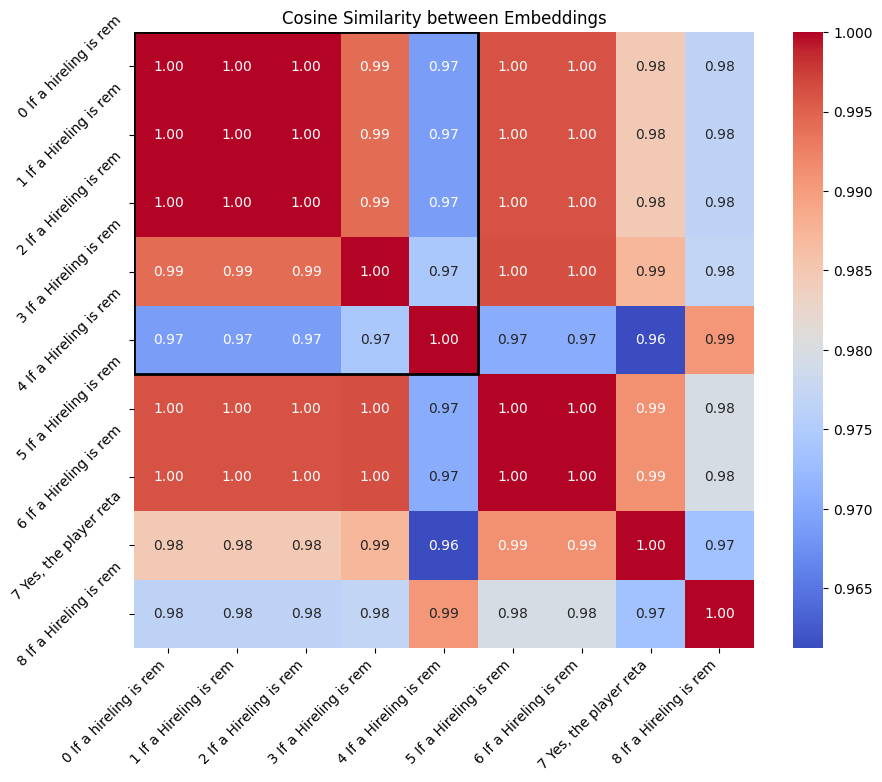

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from meeplemate.consistency import embed_responses
from matplotlib.patches import Rectangle

def visualize_response_embeddings(test_case):
    responses = test_case["good_responses"] + test_case["bad_responses"]
    good_answer_count = len(test_case["good_responses"])
    embeddings = embed_responses(jina_embedding_model, test_case["question"], responses)

    # Calculate the cosine similarity matrix
    cos_sim_matrix = cosine_similarity(embeddings)

    # Labels for your embeddings (replace these with your actual labels)
    labels = [f"{i} {response[:20]}" for i, response in enumerate(responses)]

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cos_sim_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=labels, yticklabels=labels)
    plt.title("Cosine Similarity between Embeddings")

    # Draw a box around the good responses, these should have a cosine close to 1
    rect_first_group = Rectangle((0, 0), good_answer_count, good_answer_count, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect_first_group)

    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=45)
    plt.show()

visualize_response_embeddings(test_cases[3])

In [31]:
from meeplemate.consistency import SelectionStrategy
basic_rag_chain = build_basic_rag_chain(chat_model.with_config({"callbacks": [ConsoleCallbackHandler()]}).bind(temperature=0.4))
consistency_chain = build_universal_consistency_chain(jina_embedding_model, basic_rag_chain, chat_model=chat_model.with_config({"callbacks": [ConsoleCallbackHandler()]}), response_selection_strategy="prompting_with_context")

chain = (
    {
        "documents": RunnablePassthrough() | retriever | RunnableLambda(lambda documents: documents[:5]),
        "question": RunnablePassthrough()
    }
    | consistency_chain
)

result = chain.invoke("Can I play a Go Up a Level card during combat?")

print("Question:")
print(result["question"])
print()
print()
print("Context:")
print(result["context"])
print()
print()
print("Answer:")
print(result["answer"])

[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "System: As an AI Assistant specialized in board game rules, your primary goal is to provide users with precise, understandable explanations and interpretations of game rules. Follow these key principles:\n\n- **Base your responses on the official rulebooks or authoritative sources,** recognizing that these rules hold in all standard situations unless an explicit exception is stated. Avoid assumptions and unofficial variations unless specifically requested by the user.\n\n- **Use clear, simple language** to explain rules. Avoid unnecessary jargon and ensure explanations are accessible to both new and experienced players.\n\n- **Consider the gameplay context** in your interpretations, including game phases, player counts, and specific scenarios that might impact rule application.\n\n- **Highlight rule variants and exceptions** clearly, explaining how they alter standard gameplay and under wha

### Reword Documents

Rephrasing rules from the rulebook can sometimes help the LLM to better answer questions. Here we build a chain for performing this rephrasing. This works well in conjunction with self-consistency as we can vary the context (by rewording the documents) and elicit more variety in the chain-of-thought while sampling.

In [32]:
from meeplemate.reword import build_reword_documents_chain
from langchain.schema import Document

In [33]:
excerpt_when_cards_can_be_played = """\
When You May Take Actions
You may perform these actions at any time: & Discard a Class or Race.
& Play a Go Up a Level or Hireling. Play a Curse.
You may perform these actions at any time, as long as you are not in combat: Trade an Item with another player (the other player may not be in combat, either).
y Change which Items you have equipped.
Play a card that you have just received (some cards may be played even during combat; see above).
You may perform these actions on your own turn: 3 Play a new Class or Race card (at any time).
we Sell Items for levels (except when you are in combat). Play an Item (most Items cannot be played during combat, but some one-shot Items can; see p- 3)."""

documents = [Document(page_content=excerpt_when_cards_can_be_played)]

new_documents = build_reword_documents_chain(chat_model).invoke(documents)

print(new_documents[0].page_content)

**When You May Take Actions**

You have the following options at any time, regardless of whether you are in combat:

- Discard a Class or Race.
- Play a Go Up a Level or Hireling.
- Play a Curse.

You also have these options as long as you are not in combat:

- Trade an Item with another player (the other player must also not be in combat).
- Change which Items you have equipped.
- Play a card that you have just received (some cards may be played even during combat; see above).

During your own turn, you can perform the following actions:

- Play a new Class or Race card (at any time).
- Sell Items for levels (except when you are in combat).
- Play an Item (most Items cannot be played during combat, but some one-shot Items can; see p- 3).


## Glue Code

I'm a big believer in Dependency Injection, however, at some point you need to glue the pieces together. You can either do this with a big ball of mud, or you can use a dependency injection framework. I chose the ball of mud.

```mermaid

flowchart LR
    User[Input] -->|question| Vec[(Vector DB)]
    Vec -->|docs| Filter
    User -->|question| Filter
    User -->|question| Rag
    Filter -->|docs| Rag
    subgraph U[Self-Consistency]
        direction TB
        Select[Select\nConsensus\nAnswer]
        subgraph Rag[RAG executed N times]
            Input -->|docs| Reword
            Input -->|question| CoT
            direction TB
            Reword -->|reworded\ndocs| CoT[CoT\nzero-shot]
            CoT -->|reworded docs,\nquestion, answer| Ext[Revise Answer]
            Ext -->|revised answer| Routput[Output]
        end
        Rag -->|N answers| Select
    end
    Select -->|answer| Output
```

In [34]:
from typing import Union

RetrieverWithAddDocuments = Union[ParentDocumentRetriever, VectorStoreRetrieverWithTextSplitter]

In [35]:
def build_rag_chain(
    chat_model:BaseChatModel,
    sampling_chain:Optional[Runnable]=None,
    thread_of_thought:bool=False,
) -> Runnable:
    if sampling_chain is None:
        sampling_chain = chat_model
    chat_chain = chat_model
    if thread_of_thought:
        rag_chain = build_thread_of_thought_rag_chain(
            chat_chain=chat_chain,
            sampling_chain=sampling_chain,
        )
    else:
        rag_chain = build_basic_rag_chain(
            chat_chain=chat_chain,
            sampling_chain=sampling_chain,
        )
    return rag_chain

In [36]:
rag_chain = build_rag_chain(chat_model.with_config({"callbacks": [ConsoleCallbackHandler()]}))

chain = (
    {
        "documents": RunnablePassthrough() | retriever | RunnableLambda(lambda documents: documents[:5]),
        "question": RunnablePassthrough(),
    }
    | rag_chain
)

result = chain.invoke("Can I play a Go Up a Level card during combat?")

print("Question:")
print(result["question"])
print()
print()
print("Context:")
print(result["context"])
print()
print()
print("Answer:")
print(result["answer"])

[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "System: As an AI Assistant specialized in board game rules, your primary goal is to provide users with precise, understandable explanations and interpretations of game rules. Follow these key principles:\n\n- **Base your responses on the official rulebooks or authoritative sources,** recognizing that these rules hold in all standard situations unless an explicit exception is stated. Avoid assumptions and unofficial variations unless specifically requested by the user.\n\n- **Use clear, simple language** to explain rules. Avoid unnecessary jargon and ensure explanations are accessible to both new and experienced players.\n\n- **Consider the gameplay context** in your interpretations, including game phases, player counts, and specific scenarios that might impact rule application.\n\n- **Highlight rule variants and exceptions** clearly, explaining how they alter standard gameplay and under wha

In [37]:
from meeplemate.qa import build_qa_chain

# def build_complete_chain(
#         chat_model, 
#         tokenizer, 
#         vectorstore,
#         embedding_model,
#         reword_documents=True,
#         self_consistency=True,
#         document_llm_filter=True,
#         sampling_kwargs:Optional[dict]=None,
#         retriever_kwargs:Optional[dict]=None,
#         rag_kwargs:Optional[dict]=None,
#         limit_number_of_documents:Optional[int]=5,
# ) -> Tuple[RetrieverWithAddDocuments, Runnable]:
#     if sampling_kwargs is None:
#         sampling_kwargs = {"temperature": 0.4, "top_k":40, "top_p":0.9}
#     if retriever_kwargs is None:
#         retriever_kwargs = {}
#     if rag_kwargs is None:
#         rag_kwargs = {}

#     base_retriever = build_retriever(tokenizer, vectorstore, **retriever_kwargs)
#     retriever = base_retriever
#     if limit_number_of_documents is not None:
#         retriever = retriever | RunnableLambda(lambda x: x[:limit_number_of_documents])

#     if document_llm_filter:
#         from langchain.retrievers.document_compressors import LLMChainFilter
#         _filter = LLMChainFilter.from_llm(chat_model)
#         retriever = (
#             {
#                 "query": RunnablePassthrough(),
#                 "documents": RunnablePassthrough() | retriever,
#             }
#             | RunnableLambda(lambda x: _filter.compress_documents(x["documents"], x["query"]))
#         )

#     sampling_chain = chat_model.bind(**sampling_kwargs)
#     rag_sampling_chain = sampling_chain if self_consistency else chat_model
#     rag_chain = build_rag_chain(chat_model, rag_sampling_chain, **rag_kwargs)
#     if reword_documents:
#         reword_chat_chain = sampling_chain if self_consistency else chat_model
#         reword_chain = build_reword_documents_chain(reword_chat_chain)
#         rag_chain = RunnablePassthrough.assign(documents=itemgetter("documents") | reword_chain) | rag_chain
#     if self_consistency:
#         rag_chain = build_universal_consistency_chain(embedding_model, rag_chain)

#     full_chain = (
#         {
#             "question": RunnablePassthrough(),
#             "documents": RunnablePassthrough() | retriever,
#         } 
#         | rag_chain
#     )

#     return base_retriever, full_chain

In [38]:
chat_model.callbacks = [ConsoleCallbackHandler()]

# # Reset the vectorstore so we can add the documents again with the appropriate
# # chunk sizes. Unfortunately, we can't just instantiate a new instance of Chroma
# # as that seems to just create a new instance of the same vectorstore. Also, we
# # cannot just delete the collection and then resuse the same instance, as then
# # we will get an error about the collection not existing >:( so we have to both
# # delete the collection and create a new instance. How annoying.
# if isinstance(db, Chroma):
#     try:
#         db.delete_collection()
#     except ValueError:
#         # we might have already delete it. Good for us!
#         pass

# db = build_vectorstore(hf_embedding_model)


# retriever, complete_chain = build_complete_chain(
#     chat_model=chat_model,
#     tokenizer=tokenizer,
#     vectorstore=db,
#     embedding_model=jina_embedding_model,
#     reword_documents=True,
#     self_consistency=True,
#     rag_kwargs={"thread_of_thought": True},
#     retriever_kwargs={},
# )
complete_chain = build_qa_chain(
    chat_model=chat_model,
    retriever=retriever,
    embedding_model=jina_embedding_model,
    reword_documents=True,
    self_consistency=True,
    thread_of_thought=True,
)
# retriever.add_documents(rule_docs)

In [39]:
query = "Can I play a Go Up a Level card during combat?"
result = complete_chain.invoke(query)

print("Context:")
print(result["context"])
print()
print("Question:")
print(result["question"])
print("Answer:")
print(result["answer"].content)

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Go Up a Level card during combat?\n> Context:\n>>>\n\"ONE-SHOT” TREASURES\nA Treasure card that says “Usable once only” is often called a “one-shot” Treasure. Most of these are used during combat to strengthen the munchkins or the monsters, and may be played from your hand or from the table. Some have other effects, however, so read the card carefully! Discard these cards as soon as the combat is over or their effect is resolved.\nOne-shot Items with a Gold Piece value may be sold for levels, just like other Items.\n\nOTHER TREASURES\nOther Treasure cards (like Go Up a Level cards) are not Items. Most of these cards say when they can be played, and whether they stay in play or are discarded. A couple of specific examples: Go Upa Level cards m

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Go Up a Level card during combat?\n> Context:\n>>>\nCHARACTER STATS\nEach character is basically a collection of weapons, armor, and magic items, with three stats: Level, Race, and Class. For instance, you might describe you

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Reword and improve clarity of the following excerpt from the board game Munchkin, without changing the meaning or the information conveyed. Use Markdown to format the text.\n\n> Context:\n>>>\n\"ONE-SHOT” TREASURES\nA Treasure card that says “Usable once only” is often called a “one-shot” Treasure. Most of these are used during combat to strengthen the munchkins o

## Evaluating

In [40]:
test_cases = [
    {
        "query": "If a monster does not pursue me because my level is too low, can I still loot the room?",
        "answer": "No, you cannot loot the room."
    },
    {
        "query": "Can I sell items from my hand to go up a level, assuming I can sell 1,000 gold pieces worth?",
        "answer": "Yes. You can sell items from your hand to go up a level."
    },
    {
        "query": "If a hireling is removed from play due to Bad Stuff, does the player retain any items the hireling was carrying?",
        "answer": "No. When a hireling is removed from play due to bad stuff, any items the hireling was carrying are also removed from play."
    },
    {
        "query": "Can I have multiple steeds equipped at the same time?",
        "answer": "No. You can only have one steed equipped at a time.",
        "answers": [
            """Based on the given rules, a player cannot have multiple Steeds equipped at the same time, unless using a Cheat! card. However, the Cheat! card does not explicitly state that it allows multiple Steeds to be equipped at the same time.""",
            """No, you cannot have multiple Steeds equipped at the same time, unless you use a Cheat! card."""
        ]
    },
    {
        "query": "Can I play a Go Up a Level card during combat on my turn?",
        "answer": "Yes. You can play a Go Up a Level card at any time."
    },
    {
        "query": "How many players can help me in a combat by adding their combat level?",
        "answer": "Only one player can help you with their combat level."
    },
    {
        "query": "Does a player retain their princess card in play if they die?",
        "answer": "Yes. A player retains their princess card in play if they die."
    },
    {
        "query": "Can I carry multiple big items so long as only one is equipped?",
        "answers": [
            """Based on the context provided, a player can carry any number of Small items but only one Big item. There is no mention of being able to carry multiple Big items as long as only one is equipped. Therefore, the answer is no, you cannot carry multiple Big items so long as only one is equipped."""
        ],
        "answer": "No. You can only carry one big item at a time."
    },
    {
        "query": "What is an item in play but not equipped called?",
        "answer": "An item in play but not equipped is called a carried item."
    },
    {
        "query": "If after breaking down the door I draw a steed face up, what are my options?",
        "answer": "You can put the steed into your hand, equip it, or treat as a monster and fight it.",
        "answers": [
            """If you draw a Steed face-up during the "Kick Open The Door" phase, you have two options: treat it as a monster or an Item. If you treat it as a monster, its Level is twice the combat bonus, and defeating it grants one Treasure and one level. Monster Enhancers can be played on Steeds being fought as monsters. If you treat it as an Item, you can add it to your hand and use it immediately or keep it for later."""
        ]
    },
    {
        "query": "When can I play a Super Munchkin card?",
        "answer": "You can play a Super Munchkin card whenever it is legal to play a Class card."
    },
    {
        "query": "Can I play a Super Munchkin card without a class card?",
        "answer": "No, you must have a class card to attach it to."
    },
    {
        "query": "What cards can I trade with other players?",
        "answer": "You can trade any item cards in play (on the table) with other players.",
        "answers": [
            "You can trade item cards with other players, as long as they are on the table and you are not in combat.",
            "You can trade Items with other players, as long as they are on the table and not in your hand. Trading is not allowed when you or the other player are in combat."
        ]
    },
    {
        "query": "When can I play a Hireling?",
        "answer": "At any time."
    },
    {
        "query": "Can I play a Hireling card if I already have a Hireling in play?",
        "answer": "No. You can only have one Hireling in play at a time."
    },
    {
        "query": "When I loot the room, is the door card drawn face up or face down?",
        "answer": "The door card is drawn face down."
    },
    {
        "query": "Can I use a card to compel another player to help me in combat if winning that combat would give me the winning level?",
        "answer": "No. You cannot compel another player to get the winning level."
    },
    {
        "query": "Can I play a Go Up a Level card on another player?",
        "answer": "Yes."
    },
    {
        "query": "Can I play a Curse while in combat?",
        "answer": "Yes. A curse may be played at any time."
    },
    {
        "query": "How can I get rid of my Class card?",
        "answer": "You can discard your Class card at any time."
    },
    {
        "query": "When can I discard a Race card?",
        "answer": "You can discard your Race card at any time.",
        "answers": [
            "You can discard a Race card at any time, causing you to lose the abilities and bonuses provided by that Race card."
        ]
    }
]

In [41]:
from langchain.evaluation.qa.eval_chain import QAEvalChain, CotQAEvalChain
from langchain_core.output_parsers.string import StrOutputParser
import copy

eval_template = """You are a teacher grading a quiz.
You are given a question, the student's answer, and 1 or more true answers, and are \
asked to score the student answer as either CORRECT or INCORRECT by comparing it to \
the true answer(s).

Write out in a step by step manner your reasoning to be sure that your \
conclusion is correct. Avoid simply stating the correct answer at the outset.
The student answer may contain additional information, it may also provide \
clarifications and exceptions to the true answer, so long as it does not \
contradict the true answer. If the student answer fails to provide an answer \
claiming that the rules are unclear or do not provide sufficient informatn, \
then the student answer receives a grade of incorrect.
There is no partial credit. Answers are either CORRECT or INCORRECT.
At the end, always output "GRADE: CORRECT" or "GRADE: INCORRECT" (without the \
quotes) to indicate your final conclusion on a line all by itself.

Example Format:
QUESTION: question here
STUDENT ANSWER: student's answer here
TRUE ANSWER 1: true answer 1 here
TRUE ANSWER 2: true answer 2 here
EXPLANATION: step by step reasoning here
GRADE: CORRECT or INCORRECT here

Grade the student answers based ONLY on their factual accuracy with respect to \
the true answer. Ignore differences in punctuation and phrasing between the \
student answer and true answer. Begin! 

QUESTION: Can I carry multiple big items so long as only one is equipped?
STUDENT ANSWER: A player can carry multiple big items, including Steeds, but only one can be equipped. If a player loses the ability to have more than one big item, they must correct the issue or discard all but one big item.
TRUE ANSWER 1: No. You can only carry one big item at a time.
EXPLANATION: The true answer states that you cannot carry more than one big item at a time. The student answer states a player can carray multiple big items. This contradicts the true answer. Therefore, the student answer is incorrect.
GRADE: INCORRECT

QUESTION: How many players can join me in a combat?
STUDENT ANSWER: In Munchkin, during combat against a monster, other players can help by adding their combat strength. Multiple players can contribute monsters to a fight using the Wandering Monster card. The player fighting the monster must defeat the combined combat strength of all the joined monsters. However, the rules do not explicitly state a maximum number of players who can contribute monsters to join a combat.
TRUE ANSWER 1: Only one player can join you in combat.
EXPLANATION: The true answer says that only one other player can join someone in combat. The student answer claims there is no maxiumum to the number of players who can join combat. Therefore, the student answer is incorrect.
GRADE: INCORRECT

QUESTION: If a hireling is removed from play due to Bad Stuff, does the player retain any items the hireling was carrying?
STUDENT ANSWER: If a Hireling is removed from play due to Bad Stuff or any other circumstances, the items the Hireling was carrying are lost, not retained by the player.
TRUE ANSWER 1: No. When a hireling is removed from play due to bad stuff, any items the hireling was carrying are also removed from play.
EXPLANATION: The student answer explains that if a Hireling is removed from play for any reason, the items the Hireling was carrying are lost and not retained by the player. The true answer states that when a hireling is removed from play due to bad stuff, the items carried by the hireling are also removed from play. Both the student answer and the true answer convey the same core information: that the player does not retain the items when the hireling is removed from play.
GRADE: CORRECT

QUESTION: When can I discard a Race card?
STUDENT ANSWER: To discard a Race card in Munchkin, you can do so to sell for a level, trade with another player, give to a player who wants it, power a Class or Race ability, or comply with a Curse or monster's Bad Stuff effect.
TRUE ANSWER 1: You can discard your Race card at any time.
EXPLANATION: The true answer states that you can discard your race at any time. The student answer suggests scenarios in which a race card might be discarded, but fails to mention the race card may be discarded at any time. Therefore, the student answer is incorrect.
GRADE: INCORRECT

QUESTION: What is an item in play but not equipped called?
STUDENT ANSWER: In Munchkin, an item that is in play but not equipped is referred to as an item turned sideways. These items are not being used during gameplay.
TRUE ANSWER 1: An item in play but not equipped is called a carried item.
EXPLANATION: The true answer states that an item in play but not equipped is called a carried item. The student answer makes no mention of a "carried item". Therefore, the student answer is incorrect.
GRADE: INCORRECT

QUESTION: {query}
STUDENT ANSWER: {result}
{answer}
EXPLANATION:"""
eval_prompt = PromptTemplate(
    input_variables=["query", "result", "answer"], template=eval_template
)

def predict_answer(test_cases, chain):
    test_cases = copy.deepcopy(test_cases)
    # Break up tests_cases into batches of 5
    batch_size = 2
    for i in range(0, len(test_cases), batch_size):
        batch = test_cases[i:i+batch_size]
        results = chain.batch([test_case["query"] for test_case in batch])
        for result, test_case in zip(results, batch):
            context = None
            if isinstance(result, dict):
                context = result.get("context")
                result = result.get("answer")
            result = result.content
            test_case["result"] = result
            if context is not None:
                test_case["context"] = context
    return test_cases


def grade(test_cases, llm):
    test_cases = copy.deepcopy(test_cases)
    for test in test_cases:
        answers = test.get("answers", [])[:]
        answers.append(test["answer"])
        answers = [f"TRUE ANSWER {i}: {answer}" for i, answer in enumerate(answers)]
        test["answer"] = '\n'.join(answers)
    eval_chain = QAEvalChain.from_llm(llm, prompt=eval_prompt)
    results = eval_chain.evaluate(examples=test_cases, predictions=test_cases)
    # It looks like, once upon a time, the eval chain did this bit for us... but
    # now it doesn't? Maybe a bug? Unclear as there seem to have been other 
    # intentional changes in behavior. Anyway, we do it ourselves now.
    results = [eval_chain._prepare_output(result) for result in results]

    # Merge the test cases and results
    for test_case, result in zip(test_cases, results):
        test_case.update(result)

    return test_cases


def print_graded(graded):
    for test_case in graded:
        reference = test_case.get("answer")
        if test_case.get("answers", []):
            reference = test_case["answers"][0]
        print("query:", test_case["query"])
        print("answer:", test_case["result"])
        print("reference:", reference)
        print("reasoning:", test_case["reasoning"])
        print("score:", test_case["score"])
        if "expected_score" in test_case:
            print("expected_score:", test_case["expected_score"])
        print()


def get_overall_score(scores):
    return sum([score["score"] or 0 for score in scores]) / len(scores)

### Grade the Grader

We have a set of QA pairs that have been evaluated by a human grader for
correctness. We use these examples to compare the performance of our llm grader
to the human grader.

In [43]:
if False:
    with open("grader_test_cases.json", "r") as f:
        grader_test_cases = json.loads(f.read())
    graded = grade(grader_test_cases, chat_model.bind(do_sample=False, max_new_tokens=1000))
    grader_got_wrong = [grade for grade in graded if grade["score"] != grade["expected_score"]]
    print_graded(grader_got_wrong)
    sum(1 if grade["score"] == grade["expected_score"] else 0 for grade in graded) / len(graded)

### Evaluate chain

In [45]:
# 22m 16.4s
# 19m 50.8s
# 18m 7.9s
# 19m 50.9s
# 18m 18.1s
# 0.7619047619047619
# 2m 54s
# 6m 20s - 0.71
# 75% 85% 80%
# 0.8095238095238095
# 0.8095238095238095
# 0.8095238095238095
# 7m38s
if True:
    predictions = predict_answer(test_cases, complete_chain)
    with open("test_cases.json", "w") as f:
        f.write(json.dumps(predictions))
    # graded = grade(predictions, chat_model)
    # print_graded(graded)
    # get_overall_score(graded)
 
if True:
    with open("test_cases.json", "r") as f:
        predictions = json.loads(f.read())
    
    for prediction in predictions:
        for test_case in test_cases:
            if test_case["query"] == prediction["query"]:
                prediction["answers"] = test_case.get("answers", [])
                break

    graded = grade(predictions, chat_model.bind(do_sample=False, max_new_tokens=1000))
    print_graded(graded)
    print("Overall score:", get_overall_score(graded))

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I sell items from my hand to go up a level, assuming I can sell 1,000 gold pieces worth?\n> Context:\n>>>\n1,000 Gold Pieces of Items to sell). Otherwise, you must give them to the lowest-Level player(s) who can carry them! If any Big items are still left over, discard them. Trading: You may trade Items (but no other cards) with other players. You may only trade Items from the table - not from your hand. You may trade at any time except when you or your trading partner are in combat — in fact, the best time to trade is when it’s not your turn, Any Ttem you receive in a trade must remain in play. You may also give Items away without a trade, to bribe other players - “Tl give you my Flaming Armor if you won't help Bob fight that dragon!” You may show yo

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: If a monster does not pursue me because my level is too low, can I still loot the room?\n> Context:\n>>>\nInterfering With Combat\nYou can interfere with others’ combats in several ways, including: Use a one-shot card. You could help ano

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: If a monster does not pursue me because my level is too low, can I still loot the room?\n> Context:\n>>>\nSuzan: Not the Yuppie Water! Noooo oe\nAric: That's +3 to me, and now we're tied, 15 to 15. Because I’m a Warrior, I win ties... so

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: If a monster does not pursue me because my level is too low, can I still loot the room?\n> Context:\n>>>\nMONSTERS\nIf drawn face-up, during the Kick Open The Door phase, monsters immediately attack the person who drew them.\nIf you get 

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I have multiple steeds equipped at the same time?\n> Context:\n>>>\nSTEEDS\nDear to a munchkin’s heart (as of now) is his mighty Steed. Because, of course, it gives bonuses. Steeds are found in the Door deck.\nNo player can have more than one Steed except by using a Cheat! card.\nSteeds are Items, and follow normal Item rules. Anything that affects an Item can affect a Steed.\nSteeds carry themselves. A Steed is “Big,” but it does not count against the number of Big items you can carry (in fact, some let you carry more Big things). The “Big” designation on Steeds is to control what Traps and Curses affect them, and to keep Thieves from pocketing them and walking off.\nThere are a few Items that specifically enhance Steeds. Steeds cannot use Items unle

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: If a hireling is removed from play due to Bad Stuff, does the player retain any items the hireling was carrying?\n> Context:\n>>>\nITEMS\nMost Treasures are Items. Items have a Gold Piece value. “No Value” is equivalent to zero Gold Piec

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I have multiple steeds equipped at the same time?\n> Context:\n>>>\nASKING FOR HELP\nIfyoucannotwinacombatonyourown,you mayaskanyotherplayer to help you. Ifhe refuses, you may ask another player, and so on, until they all turn you do

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Go Up a Level card during combat on my turn?\n> Context:\n>>>\n\"ONE-SHOT” TREASURES\nA Treasure card that says “Usable once only” is often called a “one-shot” Treasure. Most of these are used during combat to strengthen the

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Go Up a Level card during combat on my turn?\n> Context:\n>>>\nMONSTERS\nIf drawn face-up, during the Kick Open The Door phase, monsters immediately attack the person who drew them.\nIf you get a monster card any other way

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Go Up a Level card during combat on my turn?\n> Context:\n>>>\nCHARACTER STATS\nEach character is basically a collection of weapons, armor, and magic items, with three stats: Level, Race, and Class. For instance, you might d

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I carry multiple big items so long as only one is equipped?\n> Context:\n>>>\nSTEEDS\nDear to a munchkin’s heart (as of now) is his mighty Steed. Because, of course, it gives bonuses. Steeds are found in the Door deck.\nNo player c

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Does a player retain their princess card in play if they die?\n> Context:\n>>>\n\"ONE-SHOT” TREASURES\nA Treasure card that says “Usable once only” is often called a “one-shot” Treasure. Most of these are used during combat to strengthen

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Does a player retain their princess card in play if they die?\n> Context:\n>>>\nTREASURES\nTreasure cards include permanent and “one-shot” cards. Any Treasure card may be played to the table as soon as you get it, or at any time on your 

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Does a player retain their princess card in play if they die?\n> Context:\n>>>\nCHARACTER STATS\nEach character is basically a collection of weapons, armor, and magic items, with three stats: Level, Race, and Class. For instance, you mig

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
 

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: What is an item in play but not equipped called?\n> Context:\n>>>\nITEMS\nMost Treasures are Items. Items have a Gold Piece value. “No Value” is equivalent to zero Gold Pieces, and a “No Value” card is considered an Item.\nAll Items you have in play are considered “carried.” Items that are actually giving you a bonus are “equipped.” You should indicate Items that are not equipped by turning the cards sideways. You may not alter the status of your Items during a combat or while running away.\nAnyone can carry any Item (except for extra Big items; see below), but you may equip only one Headgear, one suit of Armor, one pair of Footgear, and two “I Hand” Items (or one “2 Hands” Item) . . . unless you have a card that lets you ignore these limits, such as Hire

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: What is an item in play but not equipped called?\n> Context:\n>>>\nHIRELINGS\nHirelings, Sidekicks, Monks, Minions, Comrades, and Allies are all the same for the purposes of these rules.\nHirelings are found in Door decks in some sets, T

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: What is an item in play but not equipped called?\n> Context:\n>>>\n1,000 Gold Pieces of Items to sell). Otherwise, you must give them to the lowest-Level player(s) who can carry them! If any Big items are still left over, discard them. T

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
       

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: When can I play a Super Munchkin card?\n> Context:\n>>>\nCURSES\nIf drawn face-up during the Kick Open The Door phase, Curse cards apply to the person who drew them. If acquired some other way, such as by Looting The Room, Curse cards 

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Super Munchkin card without a class card?\n> Context:\n>>>\nDeveloped by Andrew Hackard\n\nBased on Steve Jackson’s Munchkin\n\nIllustrated by John Kovalic\n\nAdditional Material by Steve Jackson, Devin Lewis, and Darryll Si

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Super Munchkin card without a class card?\n> Context:\n>>>\nCURSES\nIf drawn face-up during the Kick Open The Door phase, Curse cards apply to the person who drew them. If acquired some other way, such as by Looting The Room

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
  

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: What cards can I trade with other players?\n> Context:\n>>>\nITEMS\nMost Treasures are Items. Items have a Gold Piece value. “No Value” is equivalent to zero Gold Pieces, and a “No Value” card is considered an Item.\nAll Items you have i

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Hireling card if I already have a Hireling in play?\n> Context:\n>>>\nMUNCHKIN2 THE NEED FOR STEED\nThis set emphasizes two special types of cards: © Hirelings (you've seen a few, but this has more) © Steeds (a new card type

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Hireling card if I already have a Hireling in play?\n> Context:\n>>>\nCHARACTER CREATION\nEveryone starts as a Level | human with no class. (Heh, heh.) Munchkin characters may be either male or female. Your character's sex i

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
  

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I use a card to compel another player to help me in combat if winning that combat would give me the winning level?\n> Context:\n>>>\nASKING FOR HELP\nIfyoucannotwinacombatonyourown,you mayaskanyotherplayer to help you. Ifhe refuses

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I play a Go Up a Level card on another player?\n> Context:\n>>>\nASKING FOR HELP\nIfyoucannotwinacombatonyourown,you mayaskanyotherplayer to help you. Ifhe refuses, you may ask another player, and so on, until they all turn you down 

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: Can I use a card to compel another player to help me in combat if winning that combat would give me the winning level?\n> Context:\n>>>\nInterfering With Combat\nYou can interfere with others’ combats in several ways, including: Use a on

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: How can I get rid of my Class card?\n> Context:\n>>>\nFaster Play Rules\nFor a faster game, you can adda “phase 0” called Listen At The Door. At the start of your turn before doing anything else, draw a face-down Door card, which you may

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: How can I get rid of my Class card?\n> Context:\n>>>\nCOMBAT\nTo fight a monster, compare its combat strength to yours. Combat strength is the total of Level plus all modifiers - positive or negative - given by Items and other cards. If 

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: How can I get rid of my Class card?\n> Context:\n>>>\nConflicts Between Cards and Rules\nThis rulesheet gives the general tules. Many cards add special rules, so in most cases when the rulesheet disagrees with a card, follow the card. Ho

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: When can I discard a Race card?\n> Context:\n>>>\nITEMS\nMost Treasures are Items. Items have a Gold Piece value. “No Value” is equivalent to zero Gold Pieces, and a “No Value” card is considered an Item.\nAll Items you have in play ar

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "YES",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "YES"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: When can I discard a Race card?\n> Context:\n>>>\nFaster Play Rules\nFor a faster game, you can adda “phase 0” called Listen At The Door. At the start of your turn before doing anything else, draw a face-down Door card, which you may p

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/end] [1:llm:HuggingFaceChatModelLocal] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "NO",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "NO"
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Given the following question and context, return YES if the context is relevant to the question and NO if it isn't.\n\n> Question: When can I discard a Race card?\n> Context:\n>>>\nCHARACTER CREATION\nEveryone starts as a Level | human with no class. (Heh, heh.) Munchkin characters may be either male or female. Your character's sex is the same as your own at the sta

/workspaces/mistral-rag-game-rules/code/.venv/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "Human: Reword and improve clarity of the following excerpt from the board game Munchkin, without changing the meaning or the information conveyed. Use Markdown to format the text.\n\n> Context:\n>>>\nCHARACTER STATS\nEach character is basically a collection of weapons, armor, and magic items, with three stats: Level, Race, and Class. For instance, you might describe your character as a “Level 8 Elf Wizard with Boots of Butt-Kicking, a Staff of Napalm, and the Kneepads of Allure.” Level: This is a measure of how generally buff and studly you are. When the rules or cards refer to your Level, capitalized, they mean this number. You gain a level when you kill a monster, or when a card says that you do. You can also sell Items to buy levels (see Items). You lose a level when a card says you do. Your Level can never go below 1. However, your combat strength can be negative, if you get hit by a Cu

## Comparative Results

In [42]:
def get_parameter_combinations(parameter_grid):
    import itertools
    keys = parameter_grid.keys()
    values = parameter_grid.values()
    combinations = list(itertools.product(*values))
    return [dict(zip(keys, combination)) for combination in combinations]

In [43]:
def recursive_parameter_merge(params_a, params_b):
    merged = {}
    for key, value in params_a.items():
        if isinstance(value, dict) and key in params_b:
            merged[key] = recursive_parameter_merge(value, params_b[key])
        else:
            merged[key] = value
    for key, value in params_b.items():
        if key not in merged:
            merged[key] = value
    return merged

In [44]:
def test_objective(params, rounds=10):
    chain = build_qa_chain(**params)
    results = []
    for _ in range(rounds):
        predictions = predict_answer(copy.deepcopy(test_cases), chain)
        graded = grade(predictions, chat_model.bind(do_sample=False, max_new_tokens=1000))
        results.append(graded)
    
    count = len(results)
    overall_scores = [get_overall_score(grade) for grade in results]
    average_score = sum(overall_scores) / count
    return average_score, results

In [45]:
def evaluate_all_params(param_combinations, default_params, rounds=10, log_file=None):
    results = []
    for params in param_combinations:
        score, result = test_objective({**default_params, **params}, rounds=rounds)
        if log_file:
            log_file.write(json.dumps([score, params, result]))
            log_file.write("\n")
            log_file.flush()
        results.append((params, score, result))
    return results

### Self-Consistency Params

In [46]:
parameter_grid = {
    "response_selection_strategy": ["prompting_with_context", "prompting", "average_similarity"],
}

In [47]:
param_combinations = get_parameter_combinations(parameter_grid)
param_combinations = [{"consistency_kwargs": params} for params in param_combinations]
param_combinations

[{'consistency_kwargs': {'response_selection_strategy': 'prompting_with_context'}},
 {'consistency_kwargs': {'response_selection_strategy': 'prompting'}},
 {'consistency_kwargs': {'response_selection_strategy': 'average_similarity'}}]

In [ ]:
default_params = {
    "chat_model": chat_model,
    "retriever": retriever,
    "embedding_model": jina_embedding_model,
    "thread_of_thought": True,
    "self_consistency": True,
    "reword_documents": True,
    "document_llm_filter": True,
}
with open("evaluate_consistency_param_results.json", "w") as f:
    results = evaluate_all_params(param_combinations, default_params, rounds=3, log_file=f)


In [50]:
for score, params, _ in results:
    print(score, params)
    print()

{'consistency_kwargs': {'response_selection_strategy': 'prompting_with_context'}} 0.8571428571428571

{'consistency_kwargs': {'response_selection_strategy': 'prompting'}} 0.7936507936507936

{'consistency_kwargs': {'response_selection_strategy': 'average_similarity'}} 0.873015873015873



### QA Chain Components

In [57]:
parameter_grid = {
    "reword_documents": [True, False],
    "self_consistency": [True, False],
    "document_llm_filter": [True, False],
}

In [59]:
default_params = {
    "chat_model": chat_model,
    "retriever": retriever,
    "embedding_model": jina_embedding_model,
    "thread_of_thought": True,
}

param_combinations = get_parameter_combinations(parameter_grid)
param_combinations

[{'reword_documents': True,
  'self_consistency': True,
  'document_llm_filter': True},
 {'reword_documents': True,
  'self_consistency': True,
  'document_llm_filter': False},
 {'reword_documents': True,
  'self_consistency': False,
  'document_llm_filter': True},
 {'reword_documents': True,
  'self_consistency': False,
  'document_llm_filter': False},
 {'reword_documents': False,
  'self_consistency': True,
  'document_llm_filter': True},
 {'reword_documents': False,
  'self_consistency': True,
  'document_llm_filter': False},
 {'reword_documents': False,
  'self_consistency': False,
  'document_llm_filter': True},
 {'reword_documents': False,
  'self_consistency': False,
  'document_llm_filter': False}]

In [ ]:
results = evaluate_all_params(param_combinations, default_params)
# Save results
with open("evaluation_results.json", "w") as f:
    f.write(json.dumps(results))

In [ ]:
# 0.888888888888889 {'reword_documents': True, 'self_consistency': True, 'document_llm_filter': True}

# 0.7619047619047619 {'reword_documents': True, 'self_consistency': True, 'document_llm_filter': False}

# 0.6507936507936507 {'reword_documents': True, 'self_consistency': False, 'document_llm_filter': True}

# 0.746031746031746 {'reword_documents': True, 'self_consistency': False, 'document_llm_filter': False}

# 0.8571428571428572 {'reword_documents': False, 'self_consistency': True, 'document_llm_filter': True}

# 0.7142857142857143 {'reword_documents': False, 'self_consistency': True, 'document_llm_filter': False}

# 0.9047619047619048 {'reword_documents': False, 'self_consistency': False, 'document_llm_filter': True}

# 0.7936507936507936 {'reword_documents': False, 'self_consistency': False, 'document_llm_filter': False}

for params, score, _ in results:
    print(score, params)
    print()

0.888888888888889 {'reword_documents': True, 'self_consistency': True, 'document_llm_filter': True}

0.7619047619047619 {'reword_documents': True, 'self_consistency': True, 'document_llm_filter': False}

0.6507936507936507 {'reword_documents': True, 'self_consistency': False, 'document_llm_filter': True}

0.746031746031746 {'reword_documents': True, 'self_consistency': False, 'document_llm_filter': False}

0.8571428571428572 {'reword_documents': False, 'self_consistency': True, 'document_llm_filter': True}

0.7142857142857143 {'reword_documents': False, 'self_consistency': True, 'document_llm_filter': False}

0.9047619047619048 {'reword_documents': False, 'self_consistency': False, 'document_llm_filter': True}

0.7936507936507936 {'reword_documents': False, 'self_consistency': False, 'document_llm_filter': False}



### Context length

In [50]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    "context_percent": [0.25, 0.5, 0.75, 1],
    "parent_docs_percent": [1, 1/3, 1/6, 1/8],
    "child_docs_percent": [1/3, 1/6, 1/8],
    "chunk_overlap_percent": [0.0, 0.1, 0.2],
    "use_child_docs": [True, False]
}

all_combinations = list(ParameterGrid(param_grid))
all_combinations

def to_retriever_params(combination, context_size, min_context_use, min_doc_size):
    context_use = context_size * combination["context_percent"]
    if context_use < min_context_use:
        return False
    
    parent_docs_size = context_use * combination["parent_docs_percent"]
    if parent_docs_size < min_doc_size:
        return False
    
    number_of_docs = int(context_use / parent_docs_size)
    
    use_child_docs = combination["use_child_docs"]
    child_docs_size = parent_docs_size * combination["child_docs_percent"]
    if use_child_docs and child_docs_size < min_doc_size:
        return False
    
    return {
        "parent_chunk_size": int(parent_docs_size),
        "parent_chunk_overlap": int(parent_docs_size * combination["chunk_overlap_percent"]),
        "child_chunk_size": int(child_docs_size) if use_child_docs else 0,
        "child_chunk_overlap": int(child_docs_size * combination["chunk_overlap_percent"]) if use_child_docs else 0,
        "number_of_docs": number_of_docs,
    }

valid_retriever_params = list(
    filter(
        None, 
        (
            to_retriever_params(combination, 4096-1000-200, 1024, 125)
            for combination in all_combinations
        )
    )
)

print(f"number of valid retriever params: {len(valid_retriever_params)}")
valid_retriever_params[:2]

number of valid retriever params: 150


[{'parent_chunk_size': 1448,
  'parent_chunk_overlap': 0,
  'child_chunk_size': 482,
  'child_chunk_overlap': 0,
  'number_of_docs': 1},
 {'parent_chunk_size': 1448,
  'parent_chunk_overlap': 0,
  'child_chunk_size': 0,
  'child_chunk_overlap': 0,
  'number_of_docs': 1}]

In [51]:
type(db.index)

faiss.swigfaiss_avx2.IndexFlatL2

In [52]:
def get_new_vectorstore():
    global db
    if db and isinstance(db, Chroma):
        try:
            db.delete_collection()
        except ValueError:
            # we might have already deleted it. Good for us!
            pass

    db = build_vectorstore(embedding_model)
    return db

def build_chain(
    parent_chunk_size, 
    parent_chunk_overlap, 
    child_chunk_size, 
    child_chunk_overlap, 
    number_of_docs,
    self_consistency=0,
    self_consistency_temperature=0.7
):
    db = get_new_vectorstore()

    chat_model.callbacks = []

    retriever_config = RetrieverConfig(
        parent_chunk_size=parent_chunk_size,
        parent_chunk_overlap=parent_chunk_overlap,
        child_chunk_size=child_chunk_size,
        child_chunk_overlap=child_chunk_overlap,
        k=int(number_of_docs*2.5),
    )

    sampling_config = SamplingConfig(
        temperature=self_consistency_temperature,
        samples=self_consistency,
    )

    rag_config = RagChainConfig(
        thread_of_thought_enabled=True,
        use_self_consistency=bool(self_consistency),
        number_of_documents=number_of_docs,
    )

    retriever, complete_chain = build_complete_chain(
        chat_model=chat_model,
        tokenizer=tokenizer,
        vectorstore=db,
        retriever_config=retriever_config,
        sampling_config=sampling_config,
        rag_config=rag_config,
    )

    return retriever, complete_chain

def retriever_test_objective(
        parent_chunk_size, 
        parent_chunk_overlap, 
        child_chunk_size, 
        child_chunk_overlap, 
        number_of_docs,
        self_consistency=0,
        self_consistency_temperature=0.7
):
    retriever, complete_chain = build_chain(
        parent_chunk_size, 
        parent_chunk_overlap, 
        child_chunk_size, 
        child_chunk_overlap, 
        number_of_docs,
        self_consistency,
        self_consistency_temperature,
    )

    retriever.add_documents(rule_docs)

    number_of_rounds = 1

    # When using self consistency, we will introduce some randomness into the
    # equation, so we will need to run multiple rounds to get a good estimate
    # of the performance.
    if self_consistency:
        number_of_rounds = 3

    scores = []
    for _ in range(number_of_rounds):
        predictions = predict_answer(test_cases, complete_chain)
        graded = grade(predictions, chat_model.bind(do_sample=False, max_new_tokens=1000))
        scores.append(get_overall_score(graded))

    return sum(scores) / len(scores)

In [53]:
def test_creation():
    params = {"child_chunk_overlap": 0, "child_chunk_size": 599, "number_of_docs": 1, "parent_chunk_overlap": 0, "parent_chunk_size": 1798}
    retriever_test_objective(**params)
    

In [54]:
import time
from tqdm import tqdm

# for _ in tqdm(list(range(1800))):
#     # embedding_model.embed_documents([doc.page_content for doc in rule_docs])
#     # time.sleep(60)
#     db = get_new_vectorstore()
#     db.add_documents(rule_docs)
#     # retriever = build_retriever(tokenizer, db, RetrieverConfig())
#     # retriever.add_documents(rule_docs)

In [55]:
from tqdm import tqdm
import humanize
import psutil

def print_memory_usage():
    print(humanize.naturalsize(psutil.Process().memory_info().rss, binary=True))

def evaluate_all_params(params, logfile=None):
    results = []
    # Iterate over params and show progress bar
    for param in tqdm(params):
        score = retriever_test_objective(**param)
        print_memory_usage()
        result = [score, param]
        results.append(result)
        if logfile is not None:
            logfile.write(json.dumps(result))
            logfile.write("\n")
            logfile.flush()
    results.sort(key=itemgetter(0), reverse=True)
    return results

In [56]:
if False:
    with open("retriever_params_search.log", "w") as f:
        results = evaluate_all_params(valid_retriever_params, logfile=f)

with open("retriever_params_search.log", "r") as f:
    results = [json.loads(line) for line in f.readlines()]
    results = sorted(results, key=itemgetter(0), reverse=True)

results[:10]

[[0.8571428571428571,
  {'parent_chunk_size': 362,
   'parent_chunk_overlap': 0,
   'child_chunk_size': 0,
   'child_chunk_overlap': 0,
   'number_of_docs': 8}],
 [0.8095238095238095,
  {'parent_chunk_size': 362,
   'parent_chunk_overlap': 36,
   'child_chunk_size': 0,
   'child_chunk_overlap': 0,
   'number_of_docs': 8}],
 [0.8095238095238095,
  {'parent_chunk_size': 1448,
   'parent_chunk_overlap': 289,
   'child_chunk_size': 241,
   'child_chunk_overlap': 48,
   'number_of_docs': 1}],
 [0.8095238095238095,
  {'parent_chunk_size': 482,
   'parent_chunk_overlap': 96,
   'child_chunk_size': 0,
   'child_chunk_overlap': 0,
   'number_of_docs': 3}],
 [0.8095238095238095,
  {'parent_chunk_size': 2896,
   'parent_chunk_overlap': 0,
   'child_chunk_size': 362,
   'child_chunk_overlap': 0,
   'number_of_docs': 1}],
 [0.8095238095238095,
  {'parent_chunk_size': 482,
   'parent_chunk_overlap': 0,
   'child_chunk_size': 0,
   'child_chunk_overlap': 0,
   'number_of_docs': 6}],
 [0.8095238095238

In [57]:
new_param_grid = {
    "self_consistency": [3, 5, 7],
    "self_consistency_temperature": [0.4, 0.7, 1.0, 1.3]
}

all_combinations = []

for params in list(ParameterGrid(new_param_grid)):
    for result in results[:10]:
        all_combinations.append({**params, **result[1]})

all_combinations

[{'self_consistency': 3,
  'self_consistency_temperature': 0.4,
  'parent_chunk_size': 362,
  'parent_chunk_overlap': 0,
  'child_chunk_size': 0,
  'child_chunk_overlap': 0,
  'number_of_docs': 8},
 {'self_consistency': 3,
  'self_consistency_temperature': 0.4,
  'parent_chunk_size': 362,
  'parent_chunk_overlap': 36,
  'child_chunk_size': 0,
  'child_chunk_overlap': 0,
  'number_of_docs': 8},
 {'self_consistency': 3,
  'self_consistency_temperature': 0.4,
  'parent_chunk_size': 1448,
  'parent_chunk_overlap': 289,
  'child_chunk_size': 241,
  'child_chunk_overlap': 48,
  'number_of_docs': 1},
 {'self_consistency': 3,
  'self_consistency_temperature': 0.4,
  'parent_chunk_size': 482,
  'parent_chunk_overlap': 96,
  'child_chunk_size': 0,
  'child_chunk_overlap': 0,
  'number_of_docs': 3},
 {'self_consistency': 3,
  'self_consistency_temperature': 0.4,
  'parent_chunk_size': 2896,
  'parent_chunk_overlap': 0,
  'child_chunk_size': 362,
  'child_chunk_overlap': 0,
  'number_of_docs': 1},

In [58]:
print_memory_usage()
if False:
    write_mode = "w"
    if os.path.exists("self_consistency_params_search.log"):
        with open("self_consistency_params_search.log", "r") as f:
            results = [json.loads(line) for line in f.readlines()]
            params_already_searched = [result[1] for result in results]
            all_combinations = [
                combination 
                for combination in all_combinations 
                if combination not in params_already_searched
            ]
        write_mode = "a"
    with open("self_consistency_params_search.log", "a") as f:
        results = evaluate_all_params(all_combinations, logfile=f)

with open("self_consistency_params_search.log", "r") as f:
    results = [json.loads(line) for line in f.readlines()]
    results = sorted(results, key=itemgetter(0), reverse=True)

results[:10]

5.0 GiB


[[0.8095238095238094,
  {'self_consistency': 5,
   'self_consistency_temperature': 0.4,
   'parent_chunk_size': 1448,
   'parent_chunk_overlap': 289,
   'child_chunk_size': 241,
   'child_chunk_overlap': 48,
   'number_of_docs': 1}],
 [0.7936507936507936,
  {'self_consistency': 5,
   'self_consistency_temperature': 1.0,
   'parent_chunk_size': 482,
   'parent_chunk_overlap': 96,
   'child_chunk_size': 0,
   'child_chunk_overlap': 0,
   'number_of_docs': 3}],
 [0.746031746031746,
  {'self_consistency': 7,
   'self_consistency_temperature': 0.4,
   'parent_chunk_size': 1448,
   'parent_chunk_overlap': 289,
   'child_chunk_size': 241,
   'child_chunk_overlap': 48,
   'number_of_docs': 1}],
 [0.7301587301587302,
  {'self_consistency': 7,
   'self_consistency_temperature': 0.4,
   'parent_chunk_size': 2896,
   'parent_chunk_overlap': 579,
   'child_chunk_size': 362,
   'child_chunk_overlap': 72,
   'number_of_docs': 1}],
 [0.7301587301587301,
  {'self_consistency': 7,
   'self_consistency_t

In [59]:
retriever, chain = build_chain(**results[0][1])
retriever.add_documents(rule_docs)

In [72]:
from pprint import pprint
pprint(results[0][1])

{'child_chunk_overlap': 48,
 'child_chunk_size': 241,
 'number_of_docs': 1,
 'parent_chunk_overlap': 289,
 'parent_chunk_size': 1448,
 'self_consistency': 5,
 'self_consistency_temperature': 0.4}


In [86]:
chat_model.callbacks = [ConsoleCallbackHandler()]
chain.invoke(test_cases[20]["query"])

[llm/start] [1:llm:HuggingFaceChatModelLocal] Entering LLM run with input:
{
  "prompts": [
    "System: You are an AI assistant to help board game players find answers to their rule questions.\nHuman: You are an AI assistant to help board game players find answers to their rule questions.\n\nAnswer the question based only on the following board game rule excerpts. Do not use any other information. Never use the word \"excerpts\" in your answer. Simply refer to the context as the rules.\n\n----\n---\nNAME: munchkin_rules/munchkin_rules-1.pdf\nPAGE: 2\nPASSAGE:\nSUPER MUNCHKIN AND HALF-BREED\nThese cards may be played whenever it is legal to play a Class or Race, as long as you have an appropriate card (Class for Super Munchkin, Race for Half-Breed) to attach it to. You cannot have more than one of the same Class or Race card in play at once.\nIf you play Super Munchkin with one Class, you get all the advantages of being that Class (the ability to equip Class-only Items, monsters with p

{'question': 'When can I discard a Race card?',
 'documents': [Document(page_content="SUPER MUNCHKIN AND HALF-BREED\nThese cards may be played whenever it is legal to play a Class or Race, as long as you have an appropriate card (Class for Super Munchkin, Race for Half-Breed) to attach it to. You cannot have more than one of the same Class or Race card in play at once.\nIf you play Super Munchkin with one Class, you get all the advantages of being that Class (the ability to equip Class-only Items, monsters with penalties against that Class suffer those penalties) and none of the disadvantages (you can equip Items forbidden to that Class, and monsters do not get bonuses because of your Class). If the Class has an ability that has a cost, however, you must still pay it - you aren't that Super! If you play Super Munchkin while you have two Classes, you have all the normal advantages and disadvantages of both Classes. (All of the above is also true for Half-Breed, just for Races.)", metada

In [ ]:
# new_params = [{**result[1], "self_consistency": True} for result in results[:10]]
# with open("self_consistency_params_search.log", "w") as f:
#     results2 = evaluate_all_params(new_params, logfile=f)

# with open("self_consistency_params_search.log", "r") as f:
#     results2 = [json.loads(line) for line in f.readlines()]

# results2[:10]

In [ ]:
retriever_config = RetrieverConfig(
    max_context_size=4096,
    percent_context_use=0.75,
    parent_percent=0.15,
    parent_overlap_percent=0.1,
    child_percent=0.25,
    child_overlap_percent=0.1,
)

sampling_config = SamplingConfig(
    temperature=0.7,
    # top_k=0,
    # top_p=None,
    samples=5,
)

rag_config = RagChainConfig(
    thread_of_thought_enabled=True,
)

retriever, rag_chain_with_context = build_complete_chain(
    chat_model=chat_model,
    tokenizer=tokenizer,
    vectorstore=db,
    retriever_config=retriever_config,
    sampling_config=sampling_config,
    rag_config=rag_config,
)
# print(rag_chain_with_context)
rag_chain = rag_chain_with_context | itemgetter("answer")

In [ ]:
retriever.add_documents(rule_docs)

In [ ]:
from langchain.callbacks.tracers import ConsoleCallbackHandler

# rag_chain = build_basic_rag_chain(
#     retriever=retriever,
#     chat_chain=chat_model,
#     prompt=rag_config.rag_prompt,
# )

rag_chain_trace = rag_chain.with_config({'callbacks': [ConsoleCallbackHandler()]})

rag_chain_trace.invoke("Can I play a Go Up a Level card during combat?")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Can I play a Go Up a Level card during combat?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel] Entering Chain run with input:
{
  "input": "Can I play a Go Up a Level card during combat?"
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableParallel > 3:chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "Can I play a Go Up a Level card during combat?"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel > 3:chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "Can I play a Go Up a Level card during combat?"
}
[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableParallel] s] Exiting Chain run with output:
{
  "question": "Can I play a Go Up a Level card during combat?"
}
[chain/start] [1:chain:RunnableSequence > 4:chain:thread-of-thought] Entering Chain run with input:
{
  "question": "Can I play a Go Up a Level ca

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:404: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:404: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reli

[chain/end] [1:chain:RunnableSequence > 4:chain:thread-of-thought > 15:chain:RunnableAssign > 16:chain:RunnableParallel > 17:chain:RunnableSequence > 20:chain:chat-sampling] [39.64s] Exiting Chain run with output:
{
  "output": [
    {
      "lc": 1,
      "type": "constructor",
      "id": [
        "langchain",
        "schema",
        "messages",
        "AIMessage"
      ],
      "kwargs": {
        "content": "The question is about whether or not a \"Go Up a Level\" card can be played during combat in the game Munchkin.\n\nThe context starts with a passage from the rules of the game which lists actions that can be taken at any time and actions that can be taken on your own turn. The \"Go Up a Level\" card is listed as an action that can be taken on your own turn.\n\nThe passage then moves on to discuss disputes between cards and rules. It states that nothing can reduce a player below Level 1, but that a player can go up a level after combat only if they have defeated a monster. T

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:404: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[llm/end] [1:chain:RunnableSequence > 4:chain:thread-of-thought > 15:chain:RunnableAssign > 16:chain:RunnableParallel > 17:chain:RunnableSequence > 21:chain:RunnableBranch > 23:chain:RunnableEach > 24:chain:RunnableSequence > 26:llm:HuggingFaceChatModel] [8.73s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "No, a \"Go Up a Level\" card cannot be played during combat in the game Munchkin. According to the rules, a player can only go up a level after defeating a monster, and this must be done on their own turn. Additionally, the rules state that nothing can reduce a player below Level 1, so a player cannot use a \"Go Up a Level\" card to increase their level during combat.",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs

AIMessage(content='No, a "Go Up a Level" card cannot be played during combat in the game Munchkin. According to the rules, a player can only go up a level after defeating a monster, and this must be done on their own turn. Additionally, the rules state that nothing can reduce a player below Level 1, so a player cannot use a "Go Up a Level" card to increase their level during combat.')

In [ ]:
chain = (
    RunnablePassthrough.assign(result=itemgetter("query") | rag_chain | StrOutputParser())
    | QAEvalChain.from_llm(chat_model)
) 

chain.with_config({"callbacks": [ConsoleCallbackHandler()]}).invoke(
    {
        "query": "If a monster does not pursue me because my level is too low, can I still loot the room?",
        "result": "No, if a monster does not pursue me because my level is too low, I cannot loot the room. According to the rules, a player can only go up a level after defeating a monster in combat. If the monster does not pursue me, I cannot defeat it and therefore cannot go up a level. Additionally, the rules state that a player cannot collect rewards for defeating a monster in the middle of a combat. If I do not defeat the monster, I cannot collect any rewards. Therefore, I cannot loot the room."
        "answer": "No, you cannot loot the room.",
    }
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "query": "If a monster does not pursue me because my level is too low, can I still loot the room?",
  "answer": "No, you cannot loot the room."
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableAssign] Entering Chain run with input:
{
  "query": "If a monster does not pursue me because my level is too low, can I still loot the room?",
  "answer": "No, you cannot loot the room."
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableAssign > 3:chain:RunnableParallel] Entering Chain run with input:
{
  "query": "If a monster does not pursue me because my level is too low, can I still loot the room?",
  "answer": "No, you cannot loot the room."
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableAssign > 3:chain:RunnableParallel > 4:chain:RunnableSequence] Entering Chain run with input:
{
  "query": "If a monster does not pursue me because my level is too low, can I still loot the room?",
  

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:404: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:404: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:404: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You sh

[chain/end] [1:chain:RunnableSequence > 2:chain:RunnableAssign > 3:chain:RunnableParallel > 4:chain:RunnableSequence > 8:chain:RunnableParallel > 10:chain:thread-of-thought > 18:chain:chat-sampling] [34.94s] Exiting Chain run with output:
{
  "output": [
    {
      "lc": 1,
      "type": "constructor",
      "id": [
        "langchain",
        "schema",
        "messages",
        "AIMessage"
      ],
      "kwargs": {
        "content": "Q: If a monster does not pursue me because my level is too low, can I still loot the room?\n\nStep 1: Understand the context\n\nThe passage is from a rulesheet for the card game \"Munchkin.\" In this game, players take on the role of adventurers who fight monsters to gain levels and treasure. The rules for combat and looting are outlined in the passage.\n\nStep 2: Analyze the question\n\nThe question asks if a player can still loot the room if a monster does not pursue them because their level is too low.\n\nStep 3: Summarize the rules\n\nAccording 

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:404: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[llm/end] [1:chain:RunnableSequence > 2:chain:RunnableAssign > 3:chain:RunnableParallel > 4:chain:RunnableSequence > 8:chain:RunnableParallel > 10:chain:thread-of-thought > 19:chain:RunnableBranch > 21:chain:RunnableEach > 24:chain:RunnableSequence > 26:llm:HuggingFaceChatModel] [15.47s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "No, if a monster does not pursue me because my level is too low, I cannot loot the room. According to the rules, a player can only go up a level after defeating a monster in combat. If the monster does not pursue me, I cannot defeat it and therefore cannot go up a level. Additionally, the rules state that a player cannot collect rewards for defeating a monster in the middle of a combat. If I do not defeat the monster, I cannot collect any rewards. Therefore, I cannot loot the room.",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[llm/end] [1:chain:RunnableSequence > 2:chain:RunnableAssign > 3:chain:RunnableParallel > 4:chain:RunnableSequence > 29:chain:universal-consistency > 30:chain:RunnableSequence > 43:chain:RunnableAssign > 44:chain:RunnableParallel > 45:chain:RunnableSequence > 47:llm:HuggingFaceChatModel] s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "The most consistent response is Response 2.",
        "generation_info": null,
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "The most consistent response is Response 2."
          }
        }
      }
    ]
  ],
  "llm_output": null,
  "run": null
}
[chain/start] [1:chain:RunnableSequence > 2:chain:RunnableAssign > 3:chain:RunnableParallel > 4:chain:RunnableSequence > 29:chain:universal-consi

{'query': 'If a monster does not pursue me because my level is too low, can I still loot the room?',
 'answer': 'No, you cannot loot the room.',
 'result': 'No, if a monster does not pursue me because my level is too low, I cannot loot the room. According to the rules, a player can only go up a level after defeating a monster in combat. If the monster does not pursue me, I cannot defeat it and therefore cannot go up a level. Additionally, the rules state that a player cannot collect rewards for defeating a monster in the middle of a combat. If I do not defeat the monster, I cannot collect any rewards. Therefore, I cannot loot the room.',
 'results': 'CORRECT.'}

In [ ]:
m = "As a content reviewer, I provide multiple retrieved passages about this question; you need to answer the question.\n\nIf you don't know the answer, just say that you don't know, don't try to make up an answer.\n\n----\n\n---\nNAME: munchkin_rules/munchkin_rules-1.pdf\nPAGE: 2\nPASSAGE:\nWhen You May Take Actions\nYou may perform these actions at any time: & Discard a Class or Race.\n& Play a Go Up a Level or Hireling. Play a Curse.\nYou may perform these actions at any time, as long as you are not in combat: Trade an Item with another player (the other player may not be in combat, either).\ny Change which Items you have equipped.\nPlay a card that you have just received (some cards may be played even during combat; see above).\nYou may perform these actions on your own turn: 3 Play a new Class or Race card (at any time).\nwe Sell Items for levels (except when you are in combat). Play an Item (most Items cannot be played during combat, but some one-shot Items can; see p- 3).\n---\n\n\n---\nNAME: munchkin_rules/munchkin_rules-1.pdf\nPAGE: 1\nPASSAGE:\nConflicts Between Cards and Rules\nThis rulesheet gives the general tules. Many cards add special rules, so in most cases when the rulesheet disagrees with a card, follow the card. However, ignore any card effect that might seem to contradict one of the rules listed below unless the card explicitly says it supersedes that rule!\niL Nothing can reduce a player below Level 1, although card effects might reduce a player's or a monster's combat strength (p. 3) below I.\n2. You go up a level after combat only if you Ail a monster.\n3. You cannot collect rewards for defeating a monster (eg., Treasure, levels) in the middle of a combat. You must finish the fight before gaining any rewards.\n4. You must killa monster to reach Level 10, and you cannot force another player to help you do it.\nAny other disputes should be settled by loud arguments, with the owner of the game having the last word. You could also read the Munchkin FAQ and errata pages at munchkin.game, or start a discussion at forums.sjgames.com/, munchkin . . . unless it’s more fun to argue.\n\nSTEVE JACKSON GAMES\nYour Hand: Cards in your hand are not in play. They don’t help you, but they can’t be taken away except by cards that specifically affect “your hand.” At the end of your turn, you may have no more than five cards in your hand (see Charity, p- 2).\nCards in play may not be returned to your hand - they must be discarded or traded if you want to get rid of them.\n---\n\n----\n\nQ: Can I play a Go Up a Level card during combat?\nWalk me through this context in manageable parts step by step, summarizing and analyzing as we go.\n"
print(m)
print()
print()
print(chat_model.invoke(m).content)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


As a content reviewer, I provide multiple retrieved passages about this question; you need to answer the question.

If you don't know the answer, just say that you don't know, don't try to make up an answer.

----

---
NAME: munchkin_rules/munchkin_rules-1.pdf
PAGE: 2
PASSAGE:
When You May Take Actions
You may perform these actions at any time: & Discard a Class or Race.
& Play a Go Up a Level or Hireling. Play a Curse.
You may perform these actions at any time, as long as you are not in combat: Trade an Item with another player (the other player may not be in combat, either).
y Change which Items you have equipped.
Play a card that you have just received (some cards may be played even during combat; see above).
You may perform these actions on your own turn: 3 Play a new Class or Race card (at any time).
we Sell Items for levels (except when you are in combat). Play an Item (most Items cannot be played during combat, but some one-shot Items can; see p- 3).
---


---
NAME: munchkin_rul

In [ ]:
# # Using regular LLM interface
# from langchain.llms import VLLMOpenAI

# llm = VLLMOpenAI(
#     openai_api_key="EMPTY",
#     openai_api_base="http://localhost:8000/v1",
#     temperature=0.1,
#     # model_kwargs=dict(repetition_penalty=1.1),
#     max_tokens=2_000,
#     model_name=model_name,
#     frequency_penalty=0.2,
# )
# print(llm("[INST] Generate 10 names for a fantasy elf Paladin. [/INST] "))

1. Galadriel
2. Elrond
3. Legolas
4. Arwen
5. Thranduil
6. Faramir
7. Eärendil
8. Lúthien
9. Glorfindel
10. Celebrindor


In [ ]:
# To parse the PDFs, there are three strategies available: "fast", "hi_res", and
# "ocr_only". For the PDFs used here, "fast" retrieves a bunch of duplicate text
# in the wrong order. "hi_res" doesn't handle columns of text well and produces
# incoherent results. "ocr_only" seems to work reasonably well in this case.
rule_docs = []
for filename in data_path.glob("*.pdf"):
    print(f"Processing {filename}")
    loader = UnstructuredPDFLoader(filename, strategy="ocr_only")
    rule_docs.extend(loader.load())

Processing munchkin_rules/munchkin_rules-1.pdf


Processing munchkin_rules/puppies-rules.pdf
Processing munchkin_rules/princesses_rules.pdf
Processing munchkin_rules/munch_4_rules_20thp.pdf


In [ ]:
# Chunk text
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
chunked_documents = text_splitter.split_documents(rule_docs)

In [ ]:
!nvidia-smi

Fri Dec  1 23:51:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0 Off |                  N/A |
|  0%   47C    P8    23W / 420W |    139MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import faiss
# Load chunked documents into the FAISS index
db = FAISS.from_documents(
    chunked_documents, 
    embedding_model
)

In [ ]:
!nvidia-smi

Fri Dec  1 23:57:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0 Off |                  N/A |
|  0%   49C    P8    21W / 420W |  22475MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
prompt_template = """[INST] 
Instruction: You are an assitant to help answer questions about board game rules. Answer questions concisely and in one or two sentences. Rely upon the following passages from the rulebook when answering questions.

{context}

QUESTION:
{question} 
[/INST]"""

# text_generation_pipeline = transformers.pipeline(
#     model=model,
#     tokenizer=tokenizer,
#     task="text-generation",
#     # temperature=0.2,
#     # repetition_penalty=1.1,
#     # return_dict_in_generate=True,
#     # output_scores=True,
#     return_full_text=True,
#     max_new_tokens=1000,
# )
# text_generation_pipeline.model.config.pad_token_id = text_generation_pipeline.model.config.eos_token_id

# mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain 
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Create retriever
# retrieve_topk
retriever = db.as_retriever(search_kwargs={"k": 3})

def format_docs(docs):
    passages = []
    for i, doc in enumerate(docs):
        passages.append(f"Passage {i+1}: {doc.page_content}")
    return "\n\n".join(passages)

# Create rag chain
rag_chain = ( 
 {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | llm_chain
)

In [ ]:
import langchain
langchain.debug = False

In [ ]:
for i, test_case in enumerate(test_cases):
    # # Hack to avoid a warning about horribly inefficient our use of the GPU is
    # text_generation_pipeline.call_count = 0

    result = rag_chain.invoke(test_case["question"])

    print("input:", test_case["question"].strip())
    print("reference:", test_case["answer"].strip())
    print("prediction:", result["text"].strip())

    if i < len(test_cases) - 1:
        print()
        print()

input: If a monster does not pursue me because my level is too low, can I still loot the room?
reference: No. If a monster does not pursue you, it means you automatically run away from it. However, you still count as having been in combat and cannot loot the room.
prediction: No, if a monster does not pursue you because your level is too low, you cannot loot the room.


input: Can I sell items from my hand to go up a level, assuming I can sell 1,000 gold pieces worth?
reference: Yes. You can sell items from your hand to go up a level.
prediction: No, you cannot sell items from your hand to go up a level. You can only sell items worth a total of at least 1,000 Gold Pieces and immediately go up one level.


input: If a hireling is removed from play due to Bad Stuff, does the player retain any items the hireling was carrying?
reference: No. When a hireling is removed from play due to bad stuff, any items the hireling was carrying are also removed from play.
prediction: If a Hireling is re

In [ ]:
def ask(question):
    result = rag_chain.invoke(question)
    print("CONTEXT")
    print(result["context"])
    # for i, doc in enumerate(result["context"]):
    #     print(f"Document {i}:")
    #     print(f"{doc}")
    #     print("\n")
    print()
    print("ANSWER")
    print(result["text"].strip())

In [ ]:
ask("Can I play a Go Up a Level card during combat on my turn?")

CONTEXT
Passage 1: Hireling may be played at any time, on any turn. You cannot give a Hireling an Item to carry while you are in combat, however.

COMBAT

To fight a monster, compare its combat strength to yours. Combat strength is the total of Level plus all modifiers - positive or negative - given by Items and other cards. If the monster's combat strength is equal to yours, or greater, you lose the combat and must Run Away (see p. 5). If your combat strength totals more than the monster's — note that monsters win ties! — you kill it and goupa level (two levels for some big monsters). You'll also get the number of Treasures shown on its card.

Sometimes a card will let you get rid of the monster without killing it. This is still “winning,” but you don't get a level. Unless the ability says otherwise, you don’t get the Treasures, either. If the last monster is removed from a combat, it ends instantly.

Some monster cards have special powers that affect combat

Passage 2: killing a mons

In [ ]:
# Lets try thread of thought
prompt_template = """[INST] As a content reviewer, I provide multiple passages about this question; you need to answer the question.
Passage 1: 

Hireling may be played at any time, on any turn. You cannot give a Hireling an Item to carry while you are in combat, however.

COMBAT

To fight a monster, compare its combat strength to yours. Combat strength is the total of Level plus all modifiers - positive or negative - given by Items and other cards. If the monster's combat strength is equal to yours, or greater, you lose the combat and must Run Away (see p. 5). If your combat strength totals more than the monster's — note that monsters win ties! — you kill it and goupa level (two levels for some big monsters). You'll also get the number of Treasures shown on its card.

Sometimes a card will let you get rid of the monster without killing it. This is still “winning,” but you don't get a level. Unless the ability says otherwise, you don’t get the Treasures, either. If the last monster is removed from a combat, it ends instantly.

Some monster cards have special powers that affect combat

Passage 2: 

killing a monster, unless a card specifically allows you to win another way.

When You May Take Actions

You may perform these actions at any time: & Discard a Class or Race.

& Play a Go Up a Level or Hireling. Play a Curse.

You may perform these actions at any time, as long as you are not in combat:

Trade an Item with another player (the other player may not be in combat, either).

y Change which Items you have equipped.

Play a card that you have just received (some cards may be

played even during combat; see above).

You may perform these actions on your own turn:

3 Play a new Class or Race card (at any time).

we Sell Items for levels (except when you are in combat). Play an Item (most Items cannot be played during combat, but some one-shot Items can; see p- 3).

TURN PHASES

Your turn begins as soon as the previous player's turn ends. When your cards are arranged the way you want, go to phase iL

(1) Kick Open The Door: Draw one card from the Door deck and turn it face up.

Passage 3: 

Conflicts Between Cards and Rules

This rulesheet gives the general tules. Many cards add special rules, so in most cases when the rulesheet disagrees with a card, follow the card. However, ignore any card effect that might seem to contradict one of the rules listed below unless the card explicitly says it supersedes that rule!

iL Nothing can reduce a player below Level 1, although card effects might reduce a player's or a monster's combat strength (p. 3) below I.

2. You go up a level after combat only if you Ail a monster.

3. You cannot collect rewards for defeating a monster (eg., Treasure, levels) in the middle of a combat. You must finish the fight before gaining any rewards.

4. You must killa monster to reach Level 10, and you cannot force another player to help you do it.

Question: Can I play a Go Up a Level card during combat on my turn?
Walk me through this context in manageable parts step by step,
summarizing and analyzing as we go.
Answer:
"""

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=[],
    template=prompt_template,
)

# Create llm chain 
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Create retriever
# retrieve_topk
retriever = db.as_retriever(search_kwargs={"k": 3})

def format_docs(docs):
    passages = []
    for i, doc in enumerate(docs):
        passages.append(f"Passage {i+1}: {doc.page_content}")
    return "\n\n".join(passages)

# Create rag chain
# rag_chain = ( 
#  {"context": retriever | format_docs, "question": RunnablePassthrough()}
#     | llm_chain
# )

In [ ]:
thot_chain = llm_chain
print(thot_chain.invoke({})["text"])


Passage 1:

* Hireling can be played at any time, on any turn.
* Cannot give a Hireling an Item to carry while in combat.

Passage 2:

* You may perform these actions at any time: Discard a Class or Race, Play a Go Up a Level or Hireling, Play a Curse.
* You may perform these actions on your own turn: Play a new Class or Race card, Sell Items for levels, Play an Item.

Passage 3:

* Conflicts Between Cards and Rules.
* Nothing can reduce a player below Level 1.
* You go up a level after combat only if you kill a monster.
* You cannot collect rewards for defeating a monster in the middle of a combat.
* You must kill a monster to reach Level 10 and cannot force another player to help you do it.

Answer: No, you cannot play a Go Up a Level card during combat on your turn because the rules state that you can only go up a level after combat if you kill a monster. Additionally, the rules state that you cannot collect rewards for defeating a monster in the middle of a combat, so you would ne

In [ ]:
ask("What is the card limit for how many cards can be in my hand?")

CONTEXT
Any other disputes should be settled by loud arguments, with the owner of the game having the last word. You could also read the Munchkin FAQ and errata pages at munchkin.game, or start a discussion at forums.sjgames.com/, munchkin . . . unless it’s more fun to argue.

STEVE JACKSON GAMES

Your Hand: Cards in your hand are not in play. They don’t help you, but they can’t be taken away except by cards that specifically affect “your hand.” At the end of your turn, you may have no more than five cards in your hand (see Charity, p- 2).

Cards in play may not be returned to your hand - they must be discarded or traded if you want to get rid of them.

CHARACTER CREATION

Everyone starts as a Level | human with no class. (Heh, heh.) Munchkin characters may be either male or female. Your character's sex is the same as your own at the start of the game, unless you declare otherwise.

Anyone can carry any Item (except for extra Big items; see below), but you may equip only one Headgear, 